In [ ]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import matplotlib

from src.predictor import Predictor
from src.textvis import RGB, TextPainter
from src.embedding import TextIdCoverter
from src.model import get_model
from src.preprocessing import clean_doc

# load data

In [ ]:
# load confing
import yaml
import pickle
with open('config.yaml', 'r') as f:
    conf = yaml.load(f)
MAX_SEQUENCE_LENGTH = conf["EMBEDDING"]["MAX_SEQUENCE_LENGTH"]
T = conf["PREDICT"]["T"]

In [2]:
# load model
model = tf.keras.models.load_model('rnn_v0.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
# load data
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')

## load word_index
with open('data/word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)
conv = TextIdCoverter(word_index)

## Classify Evaluation Data

In [4]:
pred = Predictor(model, 50)

In [5]:
p_list = []
e_list = []
a_list = []
p_end_list = []
s = 100
for i in tqdm(range(0, 12500, 100)):
    p, e, a, p_end = pred.predict_with_uncertainty(X_val[i:i+s])
    p_list.append(p)
    e_list.append(e)
    a_list.append(a)
    p_end_list.append(p_end)

100%|██████████| 125/125 [21:28<00:00, 10.31s/it]


# Word Relevances

In [6]:
def get_word_contributions(p):
    dic = dict()

    for index_ in range(len(p)):
        text_ = conv.id2text(X_val[index_])
        length_ = len(text_.split())
        tmp = np.insert(np.diff(p[index_][-length_:]), 0, 0)

        for l, t in zip(tmp, text_.split(' ')):
            el = dic[t] if t in dic else None 
            if el:
                el['count'] = el['count'] + 1
                el['sum'] = el['sum'] + l
            else:
                dic[t] = {'count': 1, 'sum': l}
    return dic

In [7]:
# word relevances
p_end = np.array(p_end_list)
p_end = p_end.reshape((12500, T, MAX_SEQUENCE_LENGTH, 2))
p_end = p_end.mean(axis=1)[:, :, 1]

dic = get_word_contributions(p_end)

In [8]:
# word relevances
dictlist = []
for key, value in dic.items():
    temp = (key,value['count'], value['sum'])
    dictlist.append(temp)

In [9]:
relevant_words = list(map(lambda x: [x[0], x[1], x[2], x[2] / x[1]] , dictlist))
relevant_words.sort(key=lambda x: x[3])

In [10]:
pd.DataFrame(relevant_words[:15], columns=['word', 'count', 'r_sum', 'r_avg'])

,word,count,r_sum,r_avg
0,perfect,720,-878.976318,-1.220800
1,excellent,974,-1105.638916,-1.135153
2,superb,303,-319.403076,-1.054136
3,refreshing,79,-81.786980,-1.035278
4,finest,135,-133.113815,-0.986028
5,favorites,92,-89.736053,-0.975392
6,favorite,537,-508.950928,-0.947767
7,delightful,91,-85.684853,-0.941592
8,celebrates,9,-8.362975,-0.929219
9,unsurpassed,5,-4.509764,-0.901953


In [11]:
pd.DataFrame(reversed(relevant_words[-15:]), columns=['word', 'count', 'r_sum', 'r_avg'])

,word,count,r_sum,r_avg
0,worst,1237,1916.588867,1.549385
1,disappointing,179,240.860992,1.345592
2,unwatchable,57,75.378876,1.322436
3,insult,120,146.921219,1.224343
4,waste,646,789.251404,1.221751
5,forgettable,84,101.260231,1.205479
6,plagiarized,1,1.185938,1.185938
7,awful,833,981.871826,1.178718
8,disappointment,178,204.736938,1.150208
9,appalling,72,80.601227,1.119461


# Word Uncertainties

In [12]:
ue_list = np.array(e_list).reshape((12500, MAX_SEQUENCE_LENGTH, 2))[:, :, 1]
ua_list = np.array(a_list).reshape((12500, MAX_SEQUENCE_LENGTH, 2))[:, :, 1]

dic_u = get_word_contributions(ue_list)
dic_ua = get_word_contributions(ua_list)

In [13]:
# word uncertainties
dictlist_u = []
for key, value in dic_u.items():
    temp = (key,value['count'], value['sum'])
    dictlist_u.append(temp)
    
dictlist_ua = []
for key, value in dic_ua.items():
    temp = (key,value['count'], value['sum'])
    dictlist_ua.append(temp)

In [14]:
uncertain_words_epis = map(lambda r: (r[0], r[1], r[2], r[2] / r[1]) , dictlist_u)
uncertain_words_epis = list(uncertain_words_epis)
uncertain_words_epis.sort(key=lambda r:r[0])

uncertain_words_alea = map(lambda r: (r[0], r[1], r[2], r[2] / r[1]) , dictlist_ua)
uncertain_words_alea = list(uncertain_words_alea)
uncertain_words_alea.sort(key=lambda r:r[0])

In [15]:
relevant_words.sort(key=lambda x: x[0])

In [16]:
scatter_x = list(map(lambda x:x[3]*4*100, uncertain_words_epis))
scatter_y = list(map(lambda x:x[3], relevant_words))
scatter_xa = list(map(lambda x:x[3]*4*100, uncertain_words_alea))
scatter_z = list(map(lambda x:x[1], relevant_words))

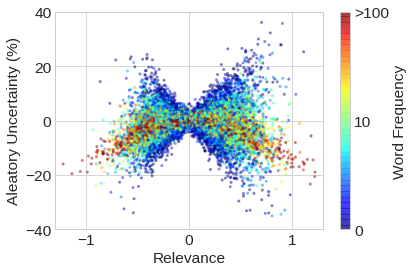

In [18]:
plt.scatter(scatter_y, scatter_xa, c =list(map(lambda x: x if x < 100 else 100,  scatter_z)), alpha=0.5, norm=matplotlib.colors.LogNorm(),cmap='jet', edgecolors='none', marker='.', rasterized=True)
plt.xlim((-1.3, 1.3))
plt.ylim((-40, 40))
cb = plt.colorbar(label='Word Frequency')
cb.set_ticks([1, 10, 100])
cb.set_ticklabels(["0", "10", ">100"])

plt.style.use('seaborn-whitegrid')
plt.rc('font', size=15.5)

plt.ylabel("Aleatory Uncertainty (%)")
plt.xlabel("Relevance")

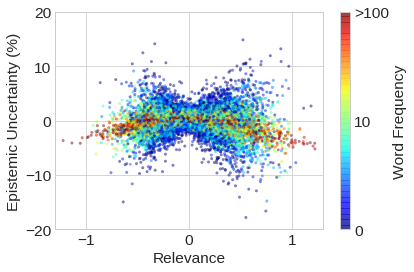

In [19]:
plt.scatter(scatter_y, scatter_x, c =list(map(lambda x: x if x < 100 else 100,  scatter_z)), alpha=0.5, norm=matplotlib.colors.LogNorm(),cmap='jet', edgecolors='none', marker='.', rasterized=True)
plt.xlim((-1.3, 1.3))
plt.ylim((-20, 20))
cb = plt.colorbar(label='Word Frequency')
cb.set_ticks([1, 10, 100])
cb.set_ticklabels(["0", "10", ">100"])

plt.style.use('seaborn-whitegrid')
plt.rc('font', size=15.5)

plt.ylabel("Epistemic Uncertainty (%)")
plt.xlabel("Relevance")